In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np

import ray
from ray.rllib.algorithms.ppo import PPOConfig

from src.parsers import HMParser
from src.resources import Vehicle
from src.algorithms.rl import EVMultiAgent_v0

2023-11-28 15:38:08,343	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
2023-11-28 15:38:08,651	WARNING deprecation.py:50 -- DeprecationWarning: `build_tf_policy` has been deprecated. This will raise an error in the future!
2023-11-28 15:38:08,655	WARNING deprecation.py:50 -- DeprecationWarning: `build_policy_class` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='C:/Users/camar/DataspellProjects/phd_thesis/pyecom/data/EC_V4.xlsx',
                ec_id=1)
data.parse()

In [3]:
# Create EVs

evs = []
for ev in np.arange(data.vehicle['e_capacity_max'].shape[0]):
    new_ev = Vehicle(name='ev_{:02d}'.format(ev + 1),
                     value=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     lower_bound=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     upper_bound=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['e_capacity_max'][ev],
                     cost = np.zeros(data.vehicle['schedule_charge'][ev].shape),
                     cost_discharge=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                    data.vehicle['discharge_price'][ev, 0],
                     cost_charge=np.ones(data.vehicle['schedule_charge'][ev].shape) * \
                                 data.vehicle['charge_price'][ev, 0],
                     capacity_max=data.vehicle['e_capacity_max'][ev],
                     initial_charge=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     min_charge=data.vehicle['min_technical_soc'][ev] * data.vehicle['e_capacity_max'][ev],
                     discharge_efficiency=data.vehicle['charge_efficiency'][ev],
                     charge_efficiency=data.vehicle['charge_efficiency'][ev],
                     schedule_connected=data.vehicle['schedule'][ev],
                     schedule_discharge=data.vehicle['schedule_discharge'][ev],
                     schedule_charge=data.vehicle['schedule_charge'][ev],
                     schedule_requirement_soc=data.vehicle['schedule_departure_soc'][ev],
                     schedule_arrival_soc=data.vehicle['schedule_arrival_soc'][ev]
                     )
    evs.append(new_ev)

In [4]:
# Create and test environment to check if everything is working

temp_env = EVMultiAgent_v0(resources=evs,
                           penalty_not_charged=100.0,
                           energy_price=data.peers['buy_price'][0, :])
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [5]:
# Aux function to assign policies

def assign_policies(env):

    policies = {}
    for agent in env.agents:
        policies[agent] = (None,
                           env.observation_space[agent],
                           env.action_space[agent],
                           {})
    return policies

policies = assign_policies(env=temp_env)

In [ ]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()

register_env("EC_EV_Multi", lambda config: EVMultiAgent_v0(resources=evs,
                                                           penalty_not_charged=100.0,
                                                           energy_price=data.peers['buy_price'][0, :]))

config = (
    PPOConfig()
    .environment(env="EC_EV_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
    .resources(num_gpus=0)
    .framework('torch')# 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: agent_id)
)
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Optimal episode reward is 0.0
checkpoint = None
MAX_ITER = 100
RESULTS = []
for i in range(MAX_ITER):
    results = algo.train()
    RESULTS.append(results)
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -20.0:
        checkpoint = algo.save()
        print("checkpoints saved")
        break

    # Save the checkpoint to disk every 10 iterations.
    if (i % 10 == 0) or (i == MAX_ITER - 1):
        checkpoint = algo.save()
        print("checkpoints saved")

In [ ]:
# Check the actions (inference)

temp_env = EVMultiAgent_v0(resources=evs,
                           penalty_not_charged=100.0,
                           energy_price=data.peers['buy_price'][0, :])
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)

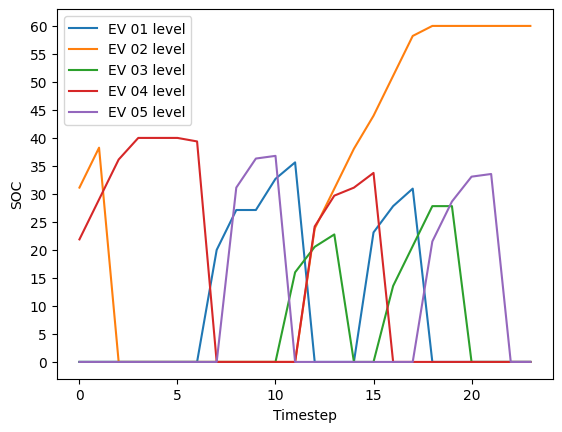

In [8]:
# Plot the EVs

for e in range(1, 6):
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['updated_soc']
               for i in range(len(episode_info) - 1)]
    plt.plot(temp_ev,
             label='EV {:02d} level'.format(e))

plt.xlabel('Timestep')
plt.ylabel('SOC')
plt.yticks(np.arange(0, 65.0, 5.0))
plt.legend()
plt.show()

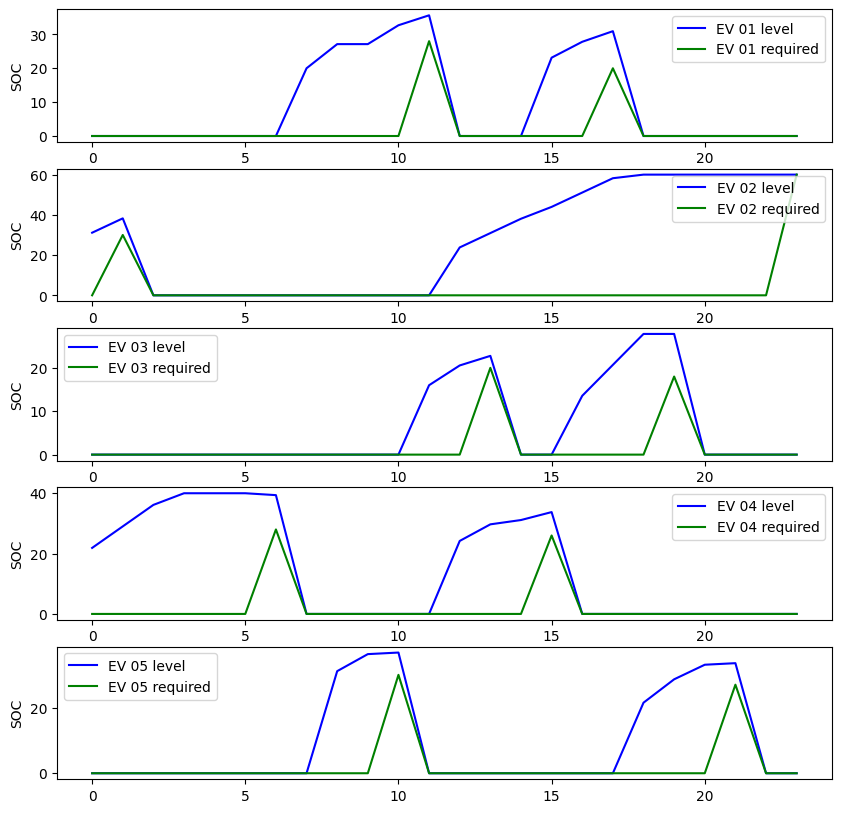

In [9]:
# Plot in separate columns and for each subplot also plot the price

fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for e in range(1, 6):
    # EV Battery level
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['updated_soc']
               for i in range(len(episode_info) - 1)]
    axs[e-1].plot(temp_ev,
                  label='EV {:02d} level'.format(e), color = 'blue')

    temp_req = [episode_info[i]['ev_{:02d}'.format(e)]['required_soc']
                for i in range(len(episode_info) - 1)]
    axs[e-1].plot(temp_req,
                  label='EV {:02d} required'.format(e), color = 'green')
    axs[e-1].legend()
    axs[e-1].set_ylabel('SOC')

plt.show()